In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shutil import copyfile

In [ ]:
# Load annotation file
train_data_path = 'E:/NN/coco/coco_wholebody_train_v1.0.json'
with open(train_data_path, 'r') as train_annotation:
    train_data = json.load(train_annotation)

In [ ]:
# Annotaion keys
train_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
# Annotation info
train_data['info']

{'description': 'COCO-WholeBody',
 'url': 'https://github.com/jin-s13/COCO-WholeBody',
 'version': '1.0',
 'year': '2020',
 'date_created': '2020/07/01'}

In [ ]:
# Need to take only image filenames
images_dict = {}

for image_dicr in train_data['images']:
    images_dict[image_dicr['id']] = image_dicr['file_name']

In [ ]:
# Lets look how many images in train dataset
len(images_dict)

118287

In [ ]:
# Image annotation dictionary keys
train_data['annotations'][0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id', 'face_box', 'lefthand_box', 'righthand_box', 'lefthand_kpts', 'righthand_kpts', 'face_kpts', 'face_valid', 'lefthand_valid', 'righthand_valid', 'foot_valid', 'foot_kpts'])

In [ ]:
# Parse only imagenames, segmentational polygons, hands bboxes and hand keypoints
images_with_hands = []
segmentations = []
hand_boxes = []
hand_keypoints = []

for annotation in train_data['annotations']:
    # l, r = 0, 0
    if (annotation['lefthand_valid'] or annotation['righthand_valid']):
        # w, h for left and right hand
        left_w, left_h = annotation['lefthand_box'][2], annotation['lefthand_box'][3]
        right_w, right_h = annotation['righthand_box'][2], annotation['righthand_box'][3]
        
        # take hands examples above square limit (w*sh > 1600 pixels)
        if left_w*left_h > 1600:
            images_with_hands.append(images_dict[annotation['image_id']])
            segmentations.append(annotation['segmentation'])
            hand_boxes.append(annotation['lefthand_box'])
            hand_keypoints.append(annotation['lefthand_kpts'])
            
        if right_w*right_h > 1600:
            images_with_hands.append(images_dict[annotation['image_id']])
            segmentations.append(annotation['segmentation'])
            hand_boxes.append(annotation['righthand_box'])
            hand_keypoints.append(annotation['righthand_kpts'])

In [ ]:
len(hand_boxes) # how many hands examples in train dataset

27700

In [ ]:
# Colors for keypoints
point_colors = [[250, 0, 0],
               [200, 0, 0],
               [150, 0, 0],
               [100, 0, 0],
               [50, 0, 0],
               [250, 250, 250],
               [200, 200, 200],
               [150, 150, 150],
               [100, 100, 100],
               [0, 250, 0],
               [0, 200, 0],
               [0, 150, 0],
               [0, 100, 0],
               [0, 250, 250],
               [0, 200, 200],
               [0, 150, 150],
               [0, 100, 100],
               [0, 0, 250],
               [0, 0, 200],
               [0, 0, 150],
               [0, 0, 100]]

# Colors for keypoint connecting lines 
line_colors = [[250, 0, 0],
              [200, 0, 0],
              [150, 0, 0],
              [100, 0, 0],
              [250, 0, 0],
              [200, 200, 200],
              [150, 150, 150],
              [100, 100, 100],
              [250, 0, 0],
              [0, 200, 0],
              [0, 150, 0],
              [0, 100, 0],
              [250, 0, 0],
              [0, 200, 200],
              [0, 150, 150],
              [0, 100, 100],
              [250, 0, 0],
              [0, 0, 200],
              [0, 0, 150],
              [0, 0, 100]]

# Indices of keypoint pairs for connection
connection_indices = [[0,1], [1,2], [2,3], [3,4],
                      [0,5], [5,6], [6,7], [7,8],
                      [0,9], [9,10], [10,11], [11,12],
                      [0,13], [13,14], [14,15], [15,16],
                      [0,17], [17,18], [18,19], [19,20]]

In [ ]:
def connect_points(keypoints_coord, is_visible, hand_img, x, y):

    '''
    Function for drawing keypoints connection lines
    Input parameters:
      - keypoints_coord - numpy array of keypoints coordinates ([x, y] * 21)
      - is_visible - flag of visibility of each keypoint ([1] * 21)
      - hand_img - cropped hand from original image
      - x - x offset of hand bbox top left corner
      - y - y offset of hand bbox top left corner
    Output parameters:
      - hand_img - hand image connected keypoints by color lines
    '''
    
    # Loop through all keypoint connection pairs
    for ind, index_pair in enumerate(connection_indices):
        # Take coordinates and visibility flag for each keypoint in pair
        point_1 = keypoints_coord[index_pair[0]]
        point_2 = keypoints_coord[index_pair[1]]
        is_vis_1 = is_visible[index_pair[0]]
        is_vis_2 = is_visible[index_pair[1]]

        # Plot line if two points are visible
        if (is_vis_1 > 0.09 and type(is_vis_1) == float) or (is_vis_1 > 1 and type(is_vis_1) == int):
            if (is_vis_2 > 0.09 and type(is_vis_2) == float) or (is_vis_2 > 1 and type(is_vis_2) == int):

                x1, y1 = int(point_1[0]) - x, int(point_1[1]) - y
                x2, y2 = int(point_2[0]) - x, int(point_2[1]) - y
                hand_img = cv2.line(hand_img, (x1, y1), (x2, y2), line_colors[ind], 1)
            
    return hand_img

In [ ]:
def plot_annotation(ind):

    '''
    Function for visual representation of segmentational polygons, hands bboxes and hand keypoints
    Input parameters:
      - ind - index of dataset example
    '''

    # Load image in rbg
    img = cv2.imread(images_path + images_with_hands[ind])
    img = img[:,:,::-1].astype(np.uint8)
    
    # Take top left coordinates and width and height of hand bbox
    x, y = max(int(hand_boxes[ind][0]), 0), max(int(hand_boxes[ind][1]), 0)
    w, h = min(x + int(hand_boxes[ind][2]), img.shape[1]), min(y + int(hand_boxes[ind][3]), img.shape[0])
    # Cut hand by its bbox
    hand_img = img[y:h, x:w,:].copy()
    # Take information about hand keypoints
    is_visible = hand_keypoints[ind][2::3]
    keypoints_coord = np.array(hand_keypoints[ind]).reshape(-1,3)[:,:2]
    # Plot keypoints in cutted hand image
    for i, point in enumerate(keypoints_coord):
        if (is_visible[i] > 0.09 and type(is_visible[i]) == float) or (is_visible[i] > 1 and type(is_visible[i]) == int):
            x_p = int(point[0]) - x
            y_p = int(point[1]) - y
            hand_img = cv2.circle(hand_img, (x_p, y_p), 1, point_colors[i], -1)
    
    # Plot lines on cutted hand image
    hand_img = connect_points(keypoints_coord, is_visible, hand_img, x, y)
    
    # Plot people polygon on original image
    for polygon in segmentations[ind]:
        pts = np.array([polygon], np.int32)
        pts = pts.reshape((-1,1,2))
        img = cv2.polylines(img, [pts], True, (0,255,255), thickness=3)

    # Plot hand bbox on original image
    img = cv2.rectangle(img, (x,y), (w,h), (255,0,255), thickness=3)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(hand_img)
    plt.show()

000000374388.jpg


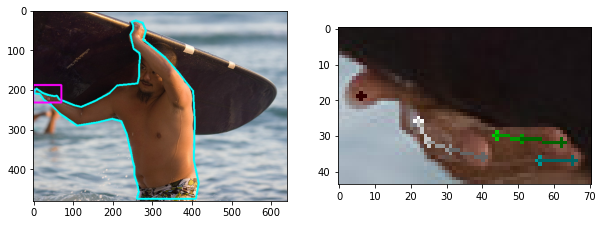

000000430167.jpg


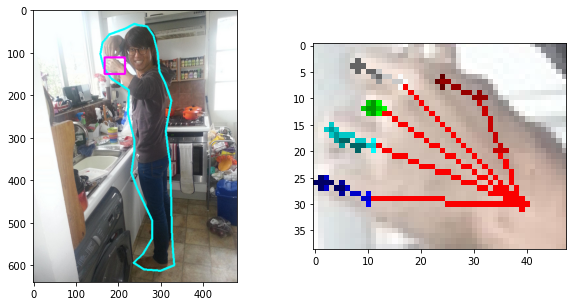

000000430167.jpg


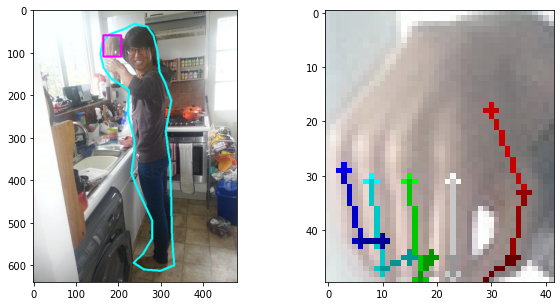

000000482237.jpg


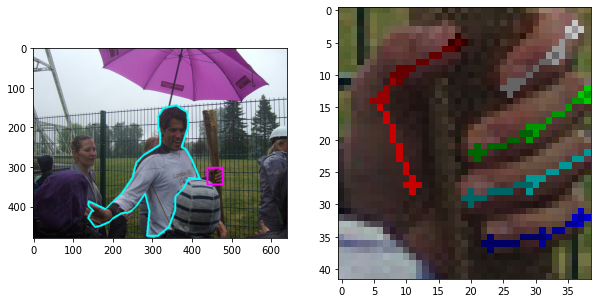

000000482237.jpg


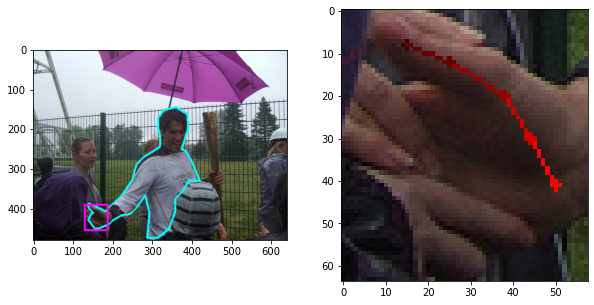

000000280122.jpg


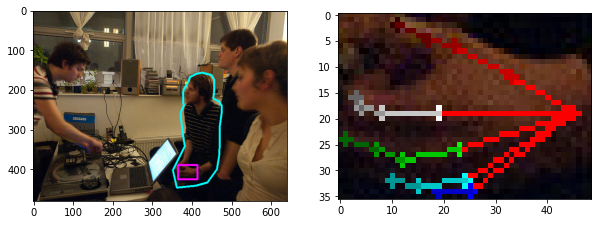

000000412238.jpg


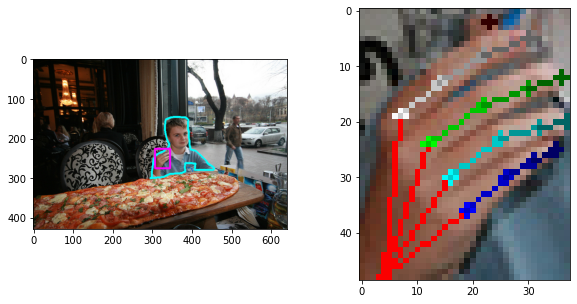

000000052208.jpg


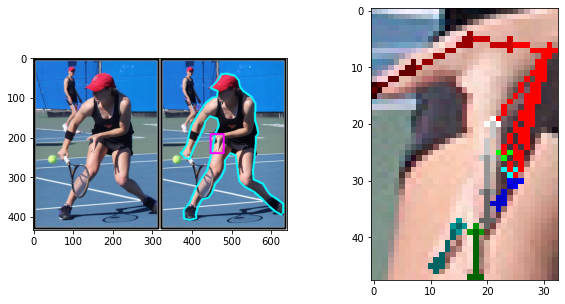

000000206602.jpg


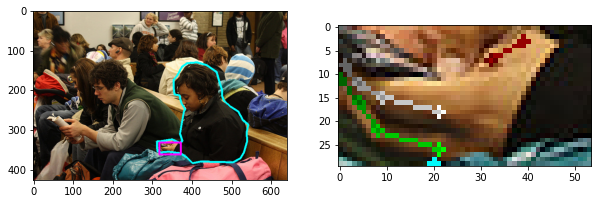

000000206602.jpg


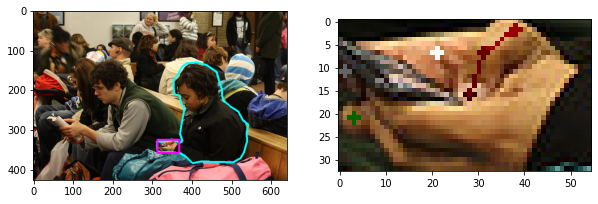

In [ ]:
# Look at some dataset examples
images_path = 'E:/NN/coco/train2017/'

ind = np.random.randint(len(hand_boxes)-20)

for i in range(ind,ind+10):
    print(images_with_hands[i])
    plot_annotation(i)

In [ ]:
# Save dataset in .cvs format
info_dict = {'image_name':images_with_hands,
            'hand_boxes': hand_boxes,
            'hand_keypoints': hand_keypoints}

df = pd.DataFrame(info_dict)
df.head()

,image_name,hand_boxes,hand_keypoints
0,000000184659.jpg,"[380.04, 93.93, 101.64999999999998, 71.06]","[477.0, 138.0, 0.2964617609977722, 464.0, 123...."
1,000000184659.jpg,"[366.14, 47.58, 93.93, 89.61]","[453.0, 69.0, 0.1306665688753128, 431.5, 89.0,..."
2,000000457254.jpg,"[292.85, 328.08, 81.5, 70.88]","[297.0, 344.0, 0.07652954012155533, 317.0, 340..."
3,000000064909.jpg,"[254.84, 432.13, 48.72, 47.56]","[289.0, 442.0, 0.05950009822845459, 277.5, 451..."
4,000000064909.jpg,"[213.33, 317.39, 61.109999999999985, 52.759999...","[214.0, 344.0, 0.13771122694015503, 231.5, 333..."


In [ ]:
df.to_csv('E:/NN/coco/train.csv', index=False)

In [ ]:
unique_filenames = np.unique(images_with_hands)
print(len(unique_filenames))

16107


In [ ]:
# Copy images with hand in separate folder
for filename in unique_filenames:
    scr = 'E:/NN/coco/train2017/' + filename
    dst = 'E:/NN/coco/hands_train/' + filename
    copyfile(scr, dst)